In [1]:
%matplotlib inline
%run ../../import_envs.py
%run ../apg_hyperparams.py
# %run ../apg_hyperparams_neural.py

CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda:0')

probtorch: 0.0+5a2c637 torch: 1.3.0


In [27]:
# load test data
# test_sets = ['pts_20', 'pts_40', 'pts_60', 'pts_80', 'pts_100']
test_sets = ['pts_100']

DATAs = []
for s in test_sets:
    data = torch.from_numpy(np.load(DATA_DIR + 'gmm/test/' + s + '/' + 'ob.npy')).float() ## load testing datasets
    DATAs.append(data)
## load the weights
# from apg_modeling_neural import init_model
from apg_modeling import init_model

model = init_model(model_params=model_params, 
                    CUDA=CUDA, 
                    DEVICE=DEVICE, 
                    LOAD_VERSION='apg-large-systematic-9sweeps-10samples',
                    LR=None)

In [38]:
## visualize samples
%run ../apg_testing.py
# from viz import viz_samples

APG_SWEEPS_TEST = 12
DATA_PTR = 108
SAVE_NAME = 'samples-%d' % DATA_PTR

datas = sample_data_uniform(DATAs=DATAs, 
                            data_ptr=DATA_PTR)


SAMPLE_SIZE_TEST = 1

from resample import Resampler
resampler = Resampler(strategy=RESAMPLING_STRATEGY,
                      sample_size=SAMPLE_SIZE_TEST,
                      CUDA=CUDA, 
                      DEVICE=DEVICE)

metrics = test_single(model=model, 
                      resampler=resampler,
                      apg_sweeps=APG_SWEEPS_TEST, 
                      datas=datas, 
                      sample_size=SAMPLE_SIZE_TEST, 
                      CUDA=CUDA, 
                      DEVICE=DEVICE)


<Figure size 432x288 with 0 Axes>

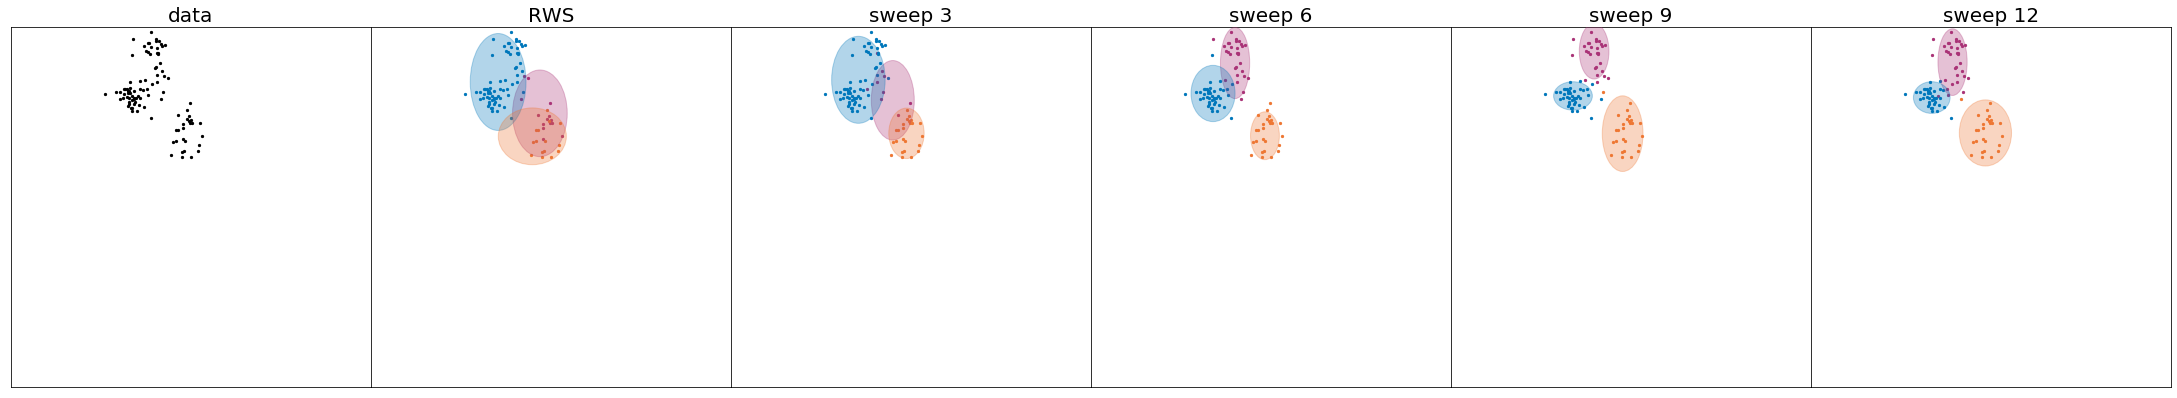

In [39]:

viz_samples(datas=datas,
            metrics=metrics,
            apg_sweeps=APG_SWEEPS_TEST,
            K=K, 
            viz_interval=3, 
            figure_size=30, 
            title_fontsize=20, 
            marker_size=5.0, 
            opacity=0.3, 
            nx=-13,
            px=20,
            ny=-28,
            py=8,
            colors=['#AA3377','#0077BB', '#EE7733', '#009988', '#BBBBBB', '#EE3377', '#DDCC77'],
            save_name=None)

In [7]:
import torch
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt

"""
==========
visualization functions
==========
"""
def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]
    if ax is None:
        ax = plt.gca()
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)
    ax.add_artist(ellip)
    return ellip

def viz_gmm(ax, ob, K, marker_size, opacity, nx, px, ny, py, colors, latents=None):
    if latents == None:
        ax.scatter(ob[:, 0], ob[:, 1], c='k', s=marker_size, zorder=3)
    else:
        (tau, mu, state) = latents
        sigma2 = 1. / tau
        assignments = state.argmax(-1)
        for k in range(K):
            cov_k = np.diag(sigma2[k])
            ob_k = ob[np.where(assignments == k)]
            ax.scatter(ob_k[:, 0], ob_k[:, 1], c=colors[k], s=marker_size, zorder=3)
            plot_cov_ellipse(cov=cov_k, pos=mu[k], nstd=2, color=colors[k], ax=ax, alpha=opacity, zorder=3)
    ax.set_ylim([ny, py])
    ax.set_xlim([nx, px])
    ax.set_xticks([])
    ax.set_yticks([])

def viz_samples(datas, metrics, apg_sweeps, K, viz_interval, figure_size, title_fontsize, marker_size, opacity, nx, px, ny, py, colors, save_name=None):
    """
    ==========
    visualize the samples along the sweeps
    ==========
    """
    num_rows = len(datas)
    num_cols = 2 + int(apg_sweeps / viz_interval)
    gs = gridspec.GridSpec(num_rows, num_cols)
    gs.update(left=0.0 , bottom=0.0, right=1.0, top=1.0, wspace=0, hspace=0)
    fig = plt.figure(figsize=(figure_size, figure_size * num_rows / num_cols))
    for row_ind, data in enumerate(datas):
        E_tau = metrics[row_ind]['E_tau'].cpu()
        E_mu = metrics[row_ind]['E_mu'].cpu()
        E_z = metrics[row_ind]['E_z'].cpu()

        ax = fig.add_subplot(gs[row_ind, 0])
        viz_gmm(ax=ax,
                ob=data,
                K=K,
                marker_size=marker_size,
                opacity=opacity,
                nx=nx,
                px=px,
                ny=ny,
                py=py,
                colors=colors,
                latents=None) ## visualize raw dataset in the 1st column
        if row_ind == 0:
            ax.set_title('data', fontsize=title_fontsize)
        col_ind = 1
        for i in range(num_cols-1):
            sweep = i * viz_interval
            ax = fig.add_subplot(gs[row_ind, i+1])
            viz_gmm(ax=ax,
                    ob=data,
                    K=K,
                    marker_size=marker_size,
                    opacity=opacity,
                    nx=nx,
                    px=px,
                    ny=ny,
                    py=py,                    
                    colors=colors,
                    latents=(E_tau[sweep, 0], E_mu[sweep, 0], E_z[sweep, 0]))
            if row_ind == 0:
                if sweep == 0:
                    ax.set_title('RWS', fontsize=title_fontsize)
                else:
                    ax.set_title('sweep %d' % sweep, fontsize=title_fontsize)
    if save_name is not None:
        plt.savefig(save_name + '.svg', dpi=300)
#
# def viz_metrics(metrics, figure_size, title_fontsize, save_name=None):
#     num_cols = len(metrics)
#     gs = gridspec.GridSpec(2, num_cols)
#     gs.update(left=0.05 , bottom=0.05, right=0.95, top=0.95, wspace=0.2, hspace=0.05)
#     fig = plt.figure(figsize=(figure_size, figure_size * 2 / num_cols))
#     for i in range(num_cols):
#         ax1 = fig.add_subplot(gs[0, i])
#         ax2 = fig.add_subplot(gs[1, i])
#         log_joints = metrics[i]['density'].squeeze(-1).cpu().data.numpy()
#         # log_p_b = metrics['marginal'][col_ind].data.numpy()
#         baseline = np.ones(ll_b.shape[0]) * ll_b[0]
#         ax1.plot(log_joints, c=self.colors[0], marker='o')
#         ax1.plot(baseline, '--', c=self.colors[1], alpha=0.4)
#         # ax1.plot(log_joint_lists[col_ind].data.numpy(), c=self.colors[0], marker='o')
#         # ax2.plot(elbo_lists[col_ind].data.numpy(), c=self.colors[1], marker='o')
#         ax2.plot(metrics['ess'][col_ind].data.numpy() / sample_size, c=colors[2])
#         ax2.scatter(np.arange(ll_b.shape[0]), metrics['ess'][col_ind].data.numpy() / sample_size, c=colors[2], s=6.0)
#         # ax3.plot(log_p_b, c=self.colors[3], marker='o')
#
#         # ax1.set_title('N= %d' % ((col_ind+1) * 20), fontsize=self.title_fontsize)
#         if col_ind == 0:
#             ax1.set_ylabel('log p(z, x)', fontsize=title_fontsize)
#             ax2.set_ylabel('ESS / L', fontsize=title_fontsize)
#             # ax3.set_ylabel('log p(x)', fontsize=self.title_fontsize)
#         ax2.set_ylim([-0.1, 1.1])
#         ax1.set_xticks([])
#         ax1.set_ylim([ll_b.min()-50, ll_b.max()+50])
#     plt.savefig(filename + '.svg', dpi=300)


In [ ]:
# budget = 1000
# apg_sweeps = [1, 2, 5]
# apg_sweeps = [1, 2, 5, 10 , 20 , 50, 100, 200]
# sample_sizes = [1000, 500, 200, 100, 50, 20, 10, 5]

apg_sweeps = [1, 5, 10 , 20, 25]
sample_sizes = [1000, 200, 100, 50, 40]
# baseline = np.array(apg_sweeps) / budget
%run ../apg_testing.py
DATA_PTR = 10

datas = sample_data_uniform(DATAs=DATAs, 
                            data_ptr=DATA_PTR)
ob = datas[0]
ESS = []
DENSITY = []
ess, density = test_budget_grid(model=model,
                                apg_sweeps=apg_sweeps,
                                sample_sizes=sample_sizes,
                                data=ob.unsqueeze(0),
                                K=K,
                                CUDA=CUDA,
                                DEVICE=DEVICE)

ess = torch.Tensor(ess).cpu()
density = torch.Tensor(density).cpu()
DENSITY.append(density)
ESS.append(ess)


In [ ]:
apg_sweeps = [1, 5, 10 , 20 , 25]
sample_sizes = [1000, 200, 100, 50, 20]


small_density = np.array([-722.2, -506.6, -453.7, -425.9, -424.8])
small_ess = np.array([0.002, 0.890, 0.952, 0.992, 0.992])

large_density = np.array([-722.2, -523.6, -451.7, -426.9, -425.8])
large_ess = np.array([0.001, 0.141, 0.706, 0.862, 0.912])

In [ ]:
import matplotlib.pyplot as plt
colors=['#AA3377', '#009988', '#EE7733', '#0077BB', '#BBBBBB', '#EE3377', '#DDCC77']
fs = 8 
fs_title = 14
lw = 3
fontsize = 20
fig = plt.figure(figsize=(fs*2.5, fs))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(np.array(apg_sweeps), small_density, 'o-', c=colors[0], linewidth=lw, label=r'$\{\mu, \tau\}, \{c\}$')
ax1.plot(np.array(apg_sweeps), large_density, 'o-', c=colors[1],  linewidth=lw,label=r'$\{\mu, \tau, c\}$')

ax1.set_xticks(np.array([1, 5, 10, 20, 25]))
ax1.set_xticklabels(['K=1\nL=1000', 'K=5\nL=200', 'K=10\nL=100', 'K=20\nL=50', 'K=25\nL=40'])
ax1.tick_params(labelsize=fontsize)
ax1.grid(alpha=0.4)

# ax1.set_xticks([])
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(np.array(apg_sweeps), small_ess, 'o-', c=colors[0],  linewidth=lw,label=r'$\{\mu, \tau\}, \{c\}$')
ax2.plot(np.array(apg_sweeps), large_ess, 'o-', c=colors[1],  linewidth=lw,label=r'$\{\mu, \tau, c\}$')
ax2.set_xticks(np.array([1, 5, 10, 20, 25]))
ax2.set_xticklabels(['K=1\nL=1000', 'K=5\nL=200', 'K=10\nL=100', 'K=20\nL=50', 'K=25\nL=40'])
ax2.tick_params(labelsize=fontsize)
ax2.grid(alpha=0.4)
ax2.legend(fontsize=fontsize)
ax1.legend(fontsize=fontsize)
ax1.set_ylabel(r'$\log \: p_\theta(x, \: z)$', fontsize=25)
ax2.set_ylabel('ESS / L', fontsize=25)
plt.savefig('bugdet_gmm.svg', dpi=300)

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.imshow(final.mean(0), cmap='inferno', vmin=-900)



apg_sweeps_ticks = ['K=1', 'K=2', 'K=5', 'K=10', 'K=20' , "K=50", 'K=100', 'K=200']
sample_sizes_ticks = ['L=1000', 'L=500', 'L=200', 'L=100', 'L=50', 'L=20', 'L=10', 'L=5']

# We want to show all ticks...
ax.set_xticks(np.arange(len(apg_sweeps)))
ax.set_yticks(np.arange(len(sample_sizes)))
# ... and label them with the respective list entries
ax.set_xticklabels(apg_sweeps_ticks, fontsize=18)
ax.set_yticklabels(sample_sizes_ticks, fontsize=18)

# # Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), ha="right",
#          rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(apg_sweeps)):
    for j in range(len(apg_sweeps)):
        text = ax.text(j, i, round(final.mean(0)[i, j], 1),
                       ha="center", va="center", color='black', fontsize=20)
# plt.savefig('heatmap_log_joint_gmm.svg', dpi=300)

In [ ]:
import numpy as np
a = np.load("heatmap_ess_gmm.npy")
np.diagonal(a.mean(0))

In [ ]:
from resample import Resampler
sample_size = 1000
resampler = Resampler(strategy='systematic',
                      sample_size=sample_size,
                      CUDA=CUDA,
                      DEVICE=DEVICE)

data = DATAs[0].unsqueeze(0).repeat(sample_size, 1, 1, 1)
if CUDA:
    ob = data.cuda().to(DEVICE)
# trace = apg_objective(model=model,
#                       resampler=resampler,
#                       apg_sweeps=apg_sweep-1,
#                       ob=ob,
#                       loss_required=loss_required,
#                       ess_required=ess_required,
#                       mode_required=mode_required, # no need to track modes during training, since modes are only for visualization purpose at test time
#                       density_required=density_required)
# density.append(trace['density'][-1].mean(0).cpu())

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
plt.plot(ess, 'o-')
apg_mean = log_joint_apg.mean(1)
apg_std = log_joint_apg.std(1)

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
for i in range(DENSITIES.shape[1]):
    density = DENSITIES[:, i]
    plt.plot(density, 'o-', label='N=%d' % pts[i])
    ax.legend()
#     ax.set_ylim([-1000, -200])

In [ ]:
# %run ../apg_testing.py


# budget = 1000
# K = [1, 2, 5, 10, 20]
# batch_size = 50
# ESS, DENSITY = test_all(model, budget, K, DATAs[0], batch_size, CUDA, DEVICE)

# import pandas as pd
# ess_df = pd.DataFrame(data=ESS)
# density_df = pd.DataFrame(data=DENSITY)
# ess_df.to_csv(path_or_buf='gmm_ess')
# density_df.to_csv(path_or_buf='gmm_density')

# import matplotlib.pyplot as plt
# density_rws = density_df['sweep=1, sample=1000'].values
# density_apg = density_df['sweep=20, sample=50'].values
# plt.plot(density_rws[:100])
# plt.plot(density_apg[:100])

In [ ]:
import numpy as np
ts_small_k9 = []
kl_small_k9 = []
f_small_k9 = open('../results/blocks_apg/previous/log-apg-small-systematic-9sweeps-10samples.txt')
for line in f_small_k9.readlines():
    line = line.strip().split(', ')
#     kl_small_k9.append(float(line[-2][11:]) / 3)
    kl_small_k9.append(float(line[0][8:]) / 3)
f_small_k9.close()
# ts_small_k9 = np.array(ts_small_k9)
kl_small_k9 = np.array(kl_small_k9)
######################################
ts_small_k4 = []
kl_small_k4 = []
f_small_k4 = open('../results/blocks_apg/previous/log-apg-small-systematic-4sweeps-20samples.txt')
for line in f_small_k4.readlines():
    line = line.strip().split(', ')
#     kl_small_k4.append(float(line[-2][11:]) / 3)
    kl_small_k4.append(float(line[0][8:]) / 3)
f_small_k4.close()
# ts_small_k4 = np.array(ts_small_k4)
kl_small_k4 = np.array(kl_small_k4)
######################################
ts_small_k1 = []
kl_small_k1 = []
f_small_k1 = open('../results/blocks_apg/previous/log-apg-small-systematic-1sweeps-50samples.txt')
for line in f_small_k1.readlines():
    line = line.strip().split(', ')
#     kl_small_k1.append(float(line[-2][11:]) / 3)
    kl_small_k1.append(float(line[0][8:]) / 3)
f_small_k1.close()
# ts_small_k1 = np.array(ts_small_k1)
kl_small_k1 = np.array(kl_small_k1)
######################################
ts_large_k9 = []
kl_large_k9 = []
f_large_k9 = open('../results/blocks_apg/previous/log-apg-large-systematic-9sweeps-10samples.txt')
for line in f_large_k9.readlines():
    line = line.strip().split(', ')
#     kl_large_k9.append(float(line[-2][11:]) / 3)
    kl_large_k9.append(float(line[0][8:]) / 3)
f_large_k9.close()
# ts_large_k9 = np.array(ts_large_k9)
kl_large_k9 = np.array(kl_large_k9)
######################################
ts_large_k4 = []
kl_large_k4 = []
f_large_k4 = open('../results/blocks_apg/previous/log-apg-large-systematic-4sweeps-20samples.txt')
for line in f_large_k4.readlines():
    line = line.strip().split(', ')
#     kl_large_k4.append(float(line[-2][11:]) / 3)
    kl_large_k4.append(float(line[0][8:]) / 3)
f_large_k4.close()
# ts_large_k4 = np.array(ts_large_k4)
kl_large_k4 = np.array(kl_large_k4)
######################################
ts_large_k1 = []
kl_large_k1 = []
f_large_k1 = open('../results/blocks_apg/previous/log-apg-large-systematic-1sweeps-50samples.txt')
for line in f_large_k1.readlines():
    line = line.strip().split(', ')
#     kl_large_k1.append(float(line[-2][11:]) / 3)
    kl_large_k1.append(float(line[0][8:]) / 3)
f_large_k1.close()
# ts_large_k1 = np.array(ts_large_k1)
kl_large_k1 = np.array(kl_large_k1)

In [ ]:
import matplotlib.pyplot as plt
colors=['#AA3377', '#009988', '#EE7733', '#0077BB', '#BBBBBB', '#EE3377', '#DDCC77']
fs = 8 
fs_title = 14
lw = 3
filename='bps100x'
OPACITY = 0.1
fig = plt.figure(figsize=(fs*2.5,fs)) 
ax1 = fig.add_subplot(1, 1, 1)
# ax2 = fig.add_subplot(1, 1, 1)

T = 100
Ts = np.arange(T) * 2
ax1.plot(Ts, kl_small_k9[:T], linewidth=lw, c=colors[0],label=r'$K=10, L=10$')
ax1.plot(Ts, kl_small_k4[:T], linewidth=lw, c=colors[1],label=r'$K=5, L=20$')
ax1.plot(Ts, kl_small_k1[:T], linewidth=lw, c=colors[2],label=r'$K=2, L=50$')

# ax1.plot(Ts, kl_small_k9[:T], linewidth=lw, c=colors[0],label=r'$(\{\mu, \tau\}, \{c\}), K=10, L=10$')
# ax1.plot(Ts, kl_small_k4[:T], linewidth=lw, c=colors[1],label=r'$(\{\mu, \tau\}, \{c\}), K=5, L=20$')
# ax1.plot(Ts, kl_small_k1[:T], linewidth=lw, c=colors[2],label=r'$(\{\mu, \tau\}, \{c\}), K=2, L=50$')

# ax2.plot(Ts, kl_large_k9[:T], linewidth=lw, c=colors[3],label=r'$(\{\mu, \tau, c\}), K=10, L=10$')
# ax2.plot(Ts, kl_large_k4[:T], linewidth=lw, c=colors[4],label=r'$(\{\mu, \tau, c\}), K=5, L=20$')
# ax2.plot(Ts, kl_large_k1[:T], linewidth=lw, c=colors[5],label=r'$(\{\mu, \tau, c\}), K=2, L=50$')


ax1.legend(fontsize=20)
ax1.tick_params(labelsize=20)
ax1.grid(alpha=0.4)
ax1.set_xlabel('Gradient Steps (thousands)', fontsize=20)
ax1.set_ylabel(r'$\mathrm{KL} \:(\: p(\mu, \tau | x,\: c) \: || \: q_\phi(\mu, \tau | x, \: c) \:)$', fontsize=25)

# ax2.legend(fontsize=20)
# ax2.tick_params(labelsize=20)
# ax2.grid(alpha=0.4)
# ax2.set_xlabel('Gradient Steps (thousands)', fontsize=20)
# ax2.set_ylabel(r'$\mathrm{KL} \:(\: p(\mu, \tau | x,\: c) \: || \: q_\phi(\mu, \tau | x, \: c) \:)$', fontsize=25)
# ax1.set_ylim([1e-4, 2])
# ax2.set_ylim([1e-4, 2])
ax1.set_yscale('log')
# ax2.set_yscale('log')
plt.savefig('kl_training_gmm.svg' , dpi=300)